Run spot-checks on Ag 3.0 data in staging bucket.

In [1]:
import pandas as pd
import gcsfs
import zarr
import allel
import dask.array as da
from dask_kubernetes import KubeCluster
from dask.distributed import Client
cluster = KubeCluster(n_workers=5)
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.38.52:38329
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-4cfff3ac-9434-11ea-8179-26737f6715e9
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.38.52:38329 Dashboard: /user/alimanfoo@googlemail.com/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register tcp://10.34.69.3:35003
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.69.3:35003
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.68.3:33789
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.68.3:33789
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.70.3:42115
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.70.3:42115
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.71.3:35279
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.71.3:35279
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.42.6:39757
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.42.6:39757
distributed.core - INFO

In [2]:
gcsfs.core.client_config['installed']['client_id'] = '160816776314-7h1p2h6bqhe77vs1su4rr22fblso9dre.apps.googleusercontent.com'
gcsfs.core.client_config['installed']['client_secret'] = 'SrJUwD58yKgViyJtw-NP2sz8'

In [4]:
# one-time browser authentication
#gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

In [5]:
# create a GCSFileSystem just for the purpose of authentication
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# create another one with those credentials
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)

In [6]:
release_path = 'vo_agam_staging/v3'

## General sample metadata

In [7]:
def load_sample_metadata(sample_set):
    with gcs.open(release_path + f'/metadata/general/{sample_set}/samples.meta.csv') as f:
        df = pd.read_csv(f)
    return df


In [8]:
df = load_sample_metadata('AG1000G-BF-B')
df

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call
0,AB0326-C,BF18-1,Austin Burt,Burkina Faso,Bana,2014,7,11.233,-4.472,F
1,AB0327-C,BF18-3,Austin Burt,Burkina Faso,Bana,2014,7,11.233,-4.472,F
2,AB0328-C,BF18-4,Austin Burt,Burkina Faso,Bana,2014,7,11.233,-4.472,F
3,AB0329-C,BF18-5,Austin Burt,Burkina Faso,Bana,2014,7,11.233,-4.472,F
4,AB0330-C,BF18-6,Austin Burt,Burkina Faso,Bana,2014,7,11.233,-4.472,F
...,...,...,...,...,...,...,...,...,...,...
97,AB0533-C,BF13-18,Austin Burt,Burkina Faso,Souroukoudinga,2014,7,11.235,-4.535,F
98,AB0536-C,BF13-31,Austin Burt,Burkina Faso,Souroukoudinga,2014,7,11.235,-4.535,F
99,AB0537-C,BF13-32,Austin Burt,Burkina Faso,Souroukoudinga,2014,7,11.235,-4.535,F
100,AB0538-C,BF13-33,Austin Burt,Burkina Faso,Souroukoudinga,2014,7,11.235,-4.535,F


In [9]:
df.groupby(['contributor', 'country', 'location', 'year', 'month']).size()

contributor  country       location        year  month
Austin Burt  Burkina Faso  Bana            2014  7        63
                           Pala            2014  7        18
                           Souroukoudinga  2014  7        21
dtype: int64

In [10]:
df = load_sample_metadata('AG1000G-ML-B')
df

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call
0,AZ0253-C,bc017,Nora Besansky,Mali,Bancoumana,2004,8,12.20,-8.20,F
1,AZ0254-C,bc047,Nora Besansky,Mali,Bancoumana,2004,8,12.20,-8.20,F
2,AZ0255-C,bc049,Nora Besansky,Mali,Bancoumana,2004,8,12.20,-8.20,F
3,AZ0256-C,bc020,Nora Besansky,Mali,Bancoumana,2004,8,12.20,-8.20,F
4,AZ0258-C,bc052,Nora Besansky,Mali,Bancoumana,2004,8,12.20,-8.20,F
...,...,...,...,...,...,...,...,...,...,...
66,VBS02119-4431STDY6772831,kl0831,Nora Besansky,Mali,Kela,2004,8,11.88,-8.45,F
67,VBS02121-4431STDY6772832,kl0836,Nora Besansky,Mali,Kela,2004,8,11.88,-8.45,F
68,VBS02127-4431STDY6772833,kl0869,Nora Besansky,Mali,Kela,2004,8,11.88,-8.45,F
69,VBS02129-4431STDY6772835,kl0884,Nora Besansky,Mali,Kela,2004,8,11.88,-8.45,F


In [11]:
df.groupby(['contributor', 'country', 'location', 'year', 'month']).size()

contributor    country  location      year  month
Nora Besansky  Mali     Bancoumana    2004  8         9
                        Douna         2004  8        20
                        Fanzana       2004  8         8
                        Kela          2004  8        23
                        Moribobougou  2004  8         7
                        N'Gabakoro    2004  8         4
dtype: int64

## Species calls

In [12]:
def load_species_calls(sample_set):
    with gcs.open(release_path + f'/metadata/species_calls_20200422/{sample_set}/samples.species_pca.csv') as f:
        df_pca = pd.read_csv(f).rename({'species_gambcolu_arabiensis': 'pca_species_gambcolu_arabiensis',
                                        'species_gambiae_coluzzii': 'pca_species_gambiae_coluzzii',}, axis=1)
    with gcs.open(release_path + f'/metadata/species_calls_20200422/{sample_set}/samples.species_aim.csv') as f:
        df_aim = pd.read_csv(f).rename({'species_gambcolu_arabiensis': 'aim_species_gambcolu_arabiensis',
                                        'species_gambiae_coluzzii': 'aim_species_gambiae_coluzzii',}, axis=1)
    df = pd.merge(df_pca, df_aim, on='sample_id')
    return df


In [13]:
df = load_species_calls('AG1000G-TZ')
df

,sample_id,PC1,PC2,pca_species_gambcolu_arabiensis,pca_species_gambiae_coluzzii,aim_fraction_colu,aim_fraction_arab,aim_species_gambcolu_arabiensis,aim_species_gambiae_coluzzii
0,BL0046-C,-27.700,-18.597,gamb_colu,gambiae,0.125,0.005,gamb_colu,intermediate
1,BL0047-C,202.946,2.731,arabiensis,NaN,0.459,0.745,arabiensis,NaN
2,BL0048-C,198.683,4.455,arabiensis,NaN,0.455,0.742,arabiensis,NaN
3,BL0049-C,202.344,4.364,arabiensis,NaN,0.455,0.744,arabiensis,NaN
4,BL0050-C,197.466,3.327,arabiensis,NaN,0.451,0.735,arabiensis,NaN
...,...,...,...,...,...,...,...,...,...
295,BL0391-C,-22.015,-49.639,gamb_colu,gambiae,0.048,0.002,gamb_colu,gambiae
296,BL0392-C,-20.633,-48.977,gamb_colu,gambiae,0.036,0.002,gamb_colu,gambiae
297,BL0393-C,-18.719,-50.235,gamb_colu,gambiae,0.041,0.006,gamb_colu,gambiae
298,BL0394-C,-26.900,-16.804,gamb_colu,gambiae,0.128,0.004,gamb_colu,intermediate


In [14]:
df.groupby(['pca_species_gambcolu_arabiensis', 'aim_species_gambcolu_arabiensis']).size()

pca_species_gambcolu_arabiensis  aim_species_gambcolu_arabiensis
arabiensis                       arabiensis                         225
gamb_colu                        gamb_colu                           75
dtype: int64

In [15]:
df.groupby(['pca_species_gambiae_coluzzii', 'aim_species_gambiae_coluzzii']).size()

pca_species_gambiae_coluzzii  aim_species_gambiae_coluzzii
gambiae                       gambiae                         68
                              intermediate                     7
dtype: int64

## SNP genotypes

In [16]:
def load_genotypes(sample_set):
    
    # load sites
    store = gcs.get_mapper(release_path + f'/snp_genotypes/all/sites')
    sites = zarr.open_consolidated(store=store)
    
    # load genotypes
    store = gcs.get_mapper(release_path + f'/snp_genotypes/all/{sample_set}')
    genotypes = zarr.open_consolidated(store=store)

    return sites, genotypes
    

In [17]:
sites, genotypes = load_genotypes('AG1000G-CM-A')

In [18]:
sites

<zarr.hierarchy.Group '/'>

In [19]:
print(sites.tree())

/
 ├── 2L
 │   ├── calldata
 │   └── variants
 │       ├── ALT (48525747, 3) |S1
 │       ├── POS (48525747,) int32
 │       └── REF (48525747,) |S1
 ├── 2R
 │   ├── calldata
 │   └── variants
 │       ├── ALT (60132453, 3) |S1
 │       ├── POS (60132453,) int32
 │       └── REF (60132453,) |S1
 ├── 3L
 │   ├── calldata
 │   └── variants
 │       ├── ALT (40758473, 3) |S1
 │       ├── POS (40758473,) int32
 │       └── REF (40758473,) |S1
 ├── 3R
 │   ├── calldata
 │   └── variants
 │       ├── ALT (52226568, 3) |S1
 │       ├── POS (52226568,) int32
 │       └── REF (52226568,) |S1
 ├── Mt
 │   ├── calldata
 │   └── variants
 │       ├── ALT (15363, 3) |S1
 │       ├── POS (15363,) int32
 │       └── REF (15363,) |S1
 ├── UNKN
 │   ├── calldata
 │   └── variants
 │       ├── ALT (27274988, 3) |S1
 │       ├── POS (27274988,) int32
 │       └── REF (27274988,) |S1
 ├── X
 │   ├── calldata
 │   └── variants
 │       ├── ALT (23385349, 3) |S1
 │       ├── POS (23385349,) int32
 │       └

In [20]:
print(genotypes.tree())

/
 ├── 2L
 │   └── calldata
 │       ├── AD (48525747, 303, 4) int16
 │       ├── GQ (48525747, 303) int16
 │       ├── GT (48525747, 303, 2) int8
 │       └── MQ (48525747, 303) int16
 ├── 2R
 │   └── calldata
 │       ├── AD (60132453, 303, 4) int16
 │       ├── GQ (60132453, 303) int16
 │       ├── GT (60132453, 303, 2) int8
 │       └── MQ (60132453, 303) int16
 ├── 3L
 │   └── calldata
 │       ├── AD (40758473, 303, 4) int16
 │       ├── GQ (40758473, 303) int16
 │       ├── GT (40758473, 303, 2) int8
 │       └── MQ (40758473, 303) int16
 ├── 3R
 │   └── calldata
 │       ├── AD (52226568, 303, 4) int16
 │       ├── GQ (52226568, 303) int16
 │       ├── GT (52226568, 303, 2) int8
 │       └── MQ (52226568, 303) int16
 ├── X
 │   └── calldata
 │       ├── AD (23385349, 303, 4) int16
 │       ├── GQ (23385349, 303) int16
 │       ├── GT (23385349, 303, 2) int8
 │       └── MQ (23385349, 303) int16
 └── samples (303,) |S24


In [23]:
a = genotypes['2R/calldata/GT']
a

<zarr.core.Array '/2R/calldata/GT' (60132453, 303, 2) int8>

In [24]:
a.chunks

(300000, 50, 2)

In [25]:
d = da.from_array(a)
d

,Array,Chunk
Bytes,36.44 GB,120.00 MB
Shape,"(60132453, 303, 2)","(600000, 100, 2)"
Count,405 Tasks,404 Chunks
Type,int8,numpy.ndarray


In [26]:
d.sum().compute()

-755139871

In [27]:
gt = allel.GenotypeDaskArray(a)
gt

<GenotypeDaskArray shape=(60132453, 303, 2) dtype=int8>

In [28]:
ac = gt.count_alleles(max_allele=3).compute()
ac

<AlleleCountsArray shape=(60132453, 4) dtype=int32>
590   0   0   0
598   0   0   0
595   2   1   0
...
0 0 0 0
0 0 0 0
0 0 0 0

In [29]:
ac.is_segregating().sum()

18536100

In [30]:
gq = da.from_array(genotypes['2R/calldata/GQ'])
gq

,Array,Chunk
Bytes,36.44 GB,120.00 MB
Shape,"(60132453, 303)","(600000, 100)"
Count,405 Tasks,404 Chunks
Type,int16,numpy.ndarray


In [31]:
import numpy as np

In [32]:
bins = np.arange(-1, 100, 1)

In [33]:
h, bins = da.histogram(gq.ravel(), bins=bins)
h = h.compute()

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<BarContainer object of 100 artists>

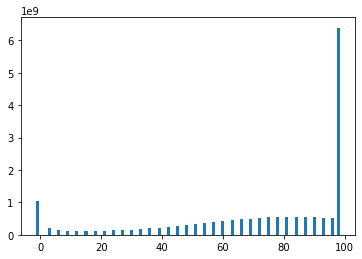

In [35]:
plt.bar(bins[:-1], h, width=1)

In [40]:
pos = sites['2R/variants/POS'][:]
pos

array([       1,        2,        3, ..., 61545103, 61545104, 61545105],
      dtype=int32)

In [41]:
is_seg = ac.is_segregating()
is_seg

array([False, False,  True, ..., False, False, False])

In [42]:
pos.shape, is_seg.shape

((60132453,), (60132453,))

In [43]:
pos_seg = pos[is_seg]
pos_seg

array([       3,        6,        8, ..., 61545043, 61545049, 61545052],
      dtype=int32)

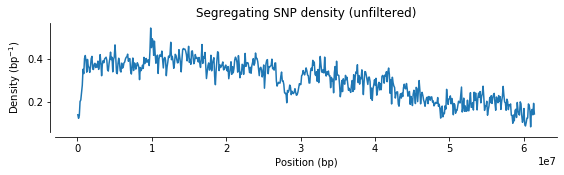

In [49]:
bin_width = 100_000
bins = np.arange(0, pos_seg.max(), bin_width)
x = (bins[1:] + bins[:-1])/2
# compute variant density
h, _ = np.histogram(pos_seg, bins=bins)
y = h / bin_width
fig, ax = plt.subplots(figsize=(9, 2))
sns.despine(ax=ax, offset=5)
ax.plot(x, y)
ax.set_xlabel('Position (bp)')
ax.set_ylabel('Density (bp$^{-1}$)')
ax.set_title('Segregating SNP density (unfiltered)');

## Site filters

In [79]:
def load_site_filters(species):
    store = gcs.get_mapper(release_path + f'/site_filters/dt_20200416/{species}')
    site_filters = zarr.open_consolidated(store=store)
    return site_filters
    

In [82]:
site_filters = load_site_filters('gamb_colu')
print(site_filters.tree())

/
 ├── 2L
 │   └── variants
 │       ├── GQ10 (48525747,) int64
 │       ├── GQ30 (48525747,) int64
 │       ├── GQ_mean (48525747,) float64
 │       ├── GQ_std (48525747,) float64
 │       ├── MQ10 (48525747,) int64
 │       ├── MQ30 (48525747,) int64
 │       ├── MQ_mean (48525747,) float64
 │       ├── MQ_std (48525747,) float64
 │       ├── allele_consistency (48525747,) int64
 │       ├── filter_pass (48525747,) bool
 │       ├── heterozygosity (48525747,) int64
 │       ├── hi_cov (48525747,) int64
 │       ├── hi_gc_normed_cov (48525747,) int64
 │       ├── lo_cov (48525747,) int64
 │       ├── lo_gc_normed_cov (48525747,) int64
 │       ├── no_cov (48525747,) int64
 │       ├── training_negative (48525747,) bool
 │       └── training_positive (48525747,) bool
 ├── 2R
 │   └── variants
 │       ├── GQ10 (60132453,) int64
 │       ├── GQ30 (60132453,) int64
 │       ├── GQ_mean (60132453,) float64
 │       ├── GQ_std (60132453,) float64
 │       ├── MQ10 (60132453,) int64
 │     

In [80]:
site_filters = load_site_filters('gamb_colu_arab')

In [81]:
print(site_filters.tree())

/
 ├── 2L
 │   └── variants
 │       └── filter_pass (48525747,) bool
 ├── 2R
 │   └── variants
 │       └── filter_pass (60132453,) bool
 ├── 3L
 │   └── variants
 │       └── filter_pass (40758473,) bool
 ├── 3R
 │   └── variants
 │       └── filter_pass (52226568,) bool
 └── X
     └── variants
         └── filter_pass (23385349,) bool


In [54]:
filter_pass = site_filters['2R/variants/filter_pass'][:]
filter_pass

array([False, False, False, ..., False, False, False])

In [56]:
filter_pass.shape

(60132453,)

In [57]:
pos.shape

(60132453,)

In [58]:
ac.shape

(60132453, 4)

In [59]:
pos_pass = pos[filter_pass]
pos_pass

array([     320,      394,      408, ..., 61545086, 61545089, 61545091],
      dtype=int32)

In [60]:
ac_pass = ac[filter_pass]
ac_pass

<AlleleCountsArray shape=(37639393, 4) dtype=int32>
606   0   0   0
606   0   0   0
 64   0   0   0
...
8 0 0 0
4 0 0 0
4 0 0 0

In [61]:
is_seg_pass = ac_pass.is_segregating()

In [66]:
pos_seg_pass = pos_pass[is_seg_pass]

In [67]:
is_seg_pass.shape

(37639393,)

In [68]:
pos_pass.shape

(37639393,)

In [69]:
pos_seg_pass.shape

(9477011,)

In [62]:
an = ac.sum(axis=1)
an

array([590, 598, 598, ...,   0,   0,   0])

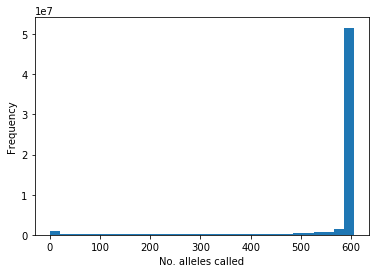

In [64]:
fig, ax = plt.subplots()
ax.hist(an, bins=30)
ax.set_xlabel('No. alleles called')
ax.set_ylabel('Frequency');

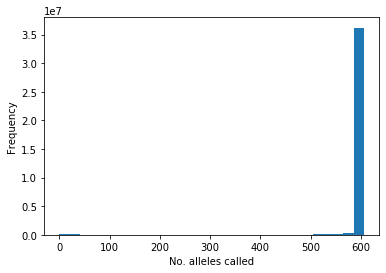

In [65]:
an_pass = ac_pass.sum(axis=1)
fig, ax = plt.subplots()
ax.hist(an_pass, bins=30)
ax.set_xlabel('No. alleles called')
ax.set_ylabel('Frequency');

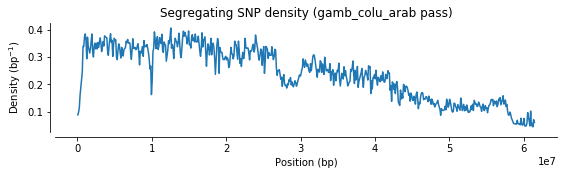

In [70]:
bin_width = 100_000
bins = np.arange(0, pos_seg.max(), bin_width)
x = (bins[1:] + bins[:-1])/2
# compute variant density
h1, _ = np.histogram(pos_seg_pass, bins=bins)
h2, _ = np.histogram(pos_pass, bins=bins)
y = h1 / h2
fig, ax = plt.subplots(figsize=(9, 2))
sns.despine(ax=ax, offset=5)
ax.plot(x, y)
ax.set_xlabel('Position (bp)')
ax.set_ylabel('Density (bp$^{-1}$)')
ax.set_title('Segregating SNP density (gamb_colu_arab pass)');

In [71]:
len(pos_seg_pass) / len(pos_pass)

0.2517843738872197

In [72]:
gt.shape

(60132453, 303, 2)

In [73]:
filter_pass.shape

(60132453,)

In [74]:
gt

<GenotypeDaskArray shape=(60132453, 303, 2) dtype=int8>

In [75]:
ac_pass_2 = gt[filter_pass].count_alleles(max_allele=3).compute()
ac_pass_2

distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


<AlleleCountsArray shape=(37639393, 4) dtype=int32>
606   0   0   0
606   0   0   0
 64   0   0   0
...
8 0 0 0
4 0 0 0
4 0 0 0

In [76]:
ac_pass

<AlleleCountsArray shape=(37639393, 4) dtype=int32>
606   0   0   0
606   0   0   0
 64   0   0   0
...
8 0 0 0
4 0 0 0
4 0 0 0

In [77]:
np.all(ac_pass == ac_pass_2)

True